In [1]:
library(tidyverse)
library(quanteda)
library(topicmodels)
library(glue)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Package version: 2.1.2

Parallel computing: 2 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘jupyter:irkernel’:

    View


The following object is masked from ‘package:utils’:

    View



Attaching package: ‘glue’


The following object is masked from 

In [5]:
sotu = read_csv("http://cssbook.net/d/sotu.csv") 
p_obama = sotu %>% filter(President == 'Obama') %>% 
  corpus()  %>% corpus_reshape('paragraphs')
dfm = p_obama %>% dfm(remove=stopwords('english'), remove_punct=T) %>% 
  dfm_trim(min_docfreq = .01, docfreq_type = "prop")
dfm


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  FirstName = col_character(),
  President = col_character(),
  Date = col_date(format = ""),
  delivery = col_character(),
  type = col_character(),
  party = col_character(),
  text = col_character()
)




Document-feature matrix of: 738 documents, 746 features (97.0% sparse) and 6 docvars.
         features
docs      speaker mr vice president members congress first united around come
  text1.1       1  1    1         1       1        1     1      1      1    0
  text1.2       0  0    0         0       0        0     0      0      0    1
  text1.3       0  0    0         0       0        0     0      0      0    0
  text1.4       0  0    0         0       0        0     0      1      0    0
  text1.5       0  0    0         0       0        0     0      0      0    0
  text1.6       0  0    0         0       0        0     0      0      0    0
[ reached max_ndoc ... 732 more documents, reached max_nfeat ... 736 more features ]

In [6]:
dfm_tm = dfm %>% convert(to = "topicmodels")

lda = LDA(dfm_tm, k = 10, control = list(seed=123, alpha = 1/1:10))
terms(lda, 10)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
college,care,us,can,years,energy,people,country,world,jobs
new,health,nation,make,first,change,get,time,american,year
workers,still,people,congress,economy,new,day,future,war,years
education,families,can,republicans,back,clean,now,american,security,new
help,americans,states,democrats,time,world,know,america,people,last
job,like,one,work,home,power,see,people,troops,tax
every,new,america,take,crisis,america,tax,done,us,million
kids,need,together,pay,financial,can,americans,work,america,$
small,must,united,cuts,two,economy,government,get,new,businesses
schools,job,president,banks,plan,research,american,now,nations,america


In [4]:
topics = posterior(lda)$topics %>% as_tibble() %>% rename_all(~paste0("Topic_", .))
tpd = bind_cols(doc_id=docnames(p_obama), 
                docvars(p_obama) %>% select(President:Date), 
                topics)
tpd %>% arrange(desc(Topic_3)) %>% head()


doc_id,President,Date,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
text7.73,Obama,2015-01-20,0.006225760,0.006215916,0.9440579,0.006217933,0.006207157,0.006213044,0.006217223,0.006219250,0.006209715,0.00621610
text5.1,Obama,2013-02-12,0.013922992,0.013920250,0.8746604,0.013945993,0.013920249,0.013922095,0.013926882,0.013934476,0.013920254,0.01392637
text4.1,Obama,2012-01-24,0.013928049,0.013941141,0.8745912,0.013940446,0.013929597,0.013926836,0.013949266,0.013934515,0.013923389,0.01393553
text6.1,Obama,2014-01-28,0.013928049,0.013941141,0.8745912,0.013940446,0.013929597,0.013926836,0.013949266,0.013934515,0.013923389,0.01393553
text2.12,Obama,2010-01-27,0.019553782,0.019579572,0.8239496,0.019602906,0.019529878,0.019576050,0.019597005,0.019541034,0.019533973,0.01953618
text2.95,Obama,2010-01-27,0.007127905,0.007119074,0.8126765,0.007138889,0.007124680,0.062978268,0.007120398,0.007120516,0.007128431,0.07446531


In [5]:
for (id in c("text7.73", "text5.1", "text2.12")) 
  cat(glue("{id}: {texts(p_obama)[id]}"), sep = "\n")


text7.73: So the question for those of us here tonight is how we, all of us, can better reflect America's hopes. I've served in Congress with many of you. I know many of you well. There are a lot of good people here on both sides of the aisle. And many of you have told me that this isn't what you signed up for: arguing past each other on cable shows, the constant fundraising, always looking over your shoulder at how the base will react to every decision.
text5.1: Mr. Speaker, Mr. Vice President, members of Congress, fellow citizens:
text2.12: And tonight, I'd like to talk about how together, we can deliver on that promise.


In [7]:
lda = LDA(dfm_tm, k = 10, control = list(seed=123, alpha = 1/1:10))
terms(lda, 10)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
college,care,us,can,years,energy,people,country,world,jobs
new,health,nation,make,first,change,get,time,american,year
workers,still,people,congress,economy,new,day,future,war,years
education,families,can,republicans,back,clean,now,american,security,new
help,americans,states,democrats,time,world,know,america,people,last
job,like,one,work,home,power,see,people,troops,tax
every,new,america,take,crisis,america,tax,done,us,million
kids,need,together,pay,financial,can,americans,work,america,$
small,must,united,cuts,two,economy,government,get,new,businesses
schools,job,president,banks,plan,research,american,now,nations,america


In [57]:
test_sample = sample(1:nrow(dfm_tm), 100)
dfm_test = dfm_tm[test_sample,]
dfm_train = dfm_tm[-test_sample,]

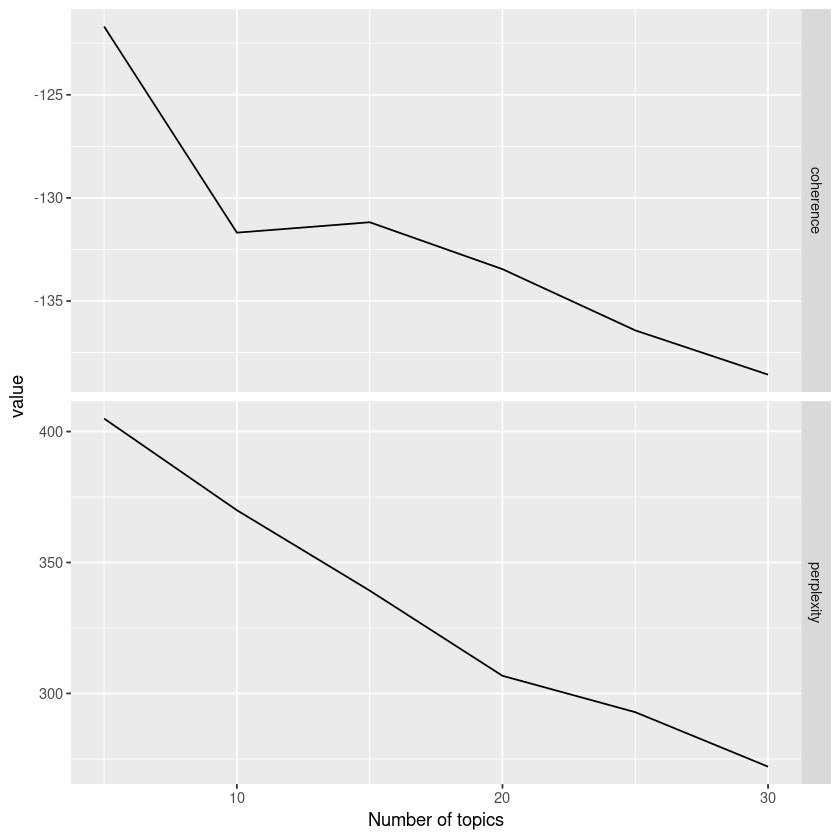

In [69]:
# install.packages("topicdoc")
library(topicdoc)
results = list()
for (k in c(5, 10, 15, 20, 25, 30)) {
    lda = LDA(dfm_tm, k = k, control = list(seed=123, alpha = 1/((1:k)+sqrt(k))))
    row = data.frame(k=k, 
      coherence=mean(topic_coherence(lda, dfm_tm)), 
      perplexity = perplexity(lda))
    results[[as.character(k)]] = 
}
bind_rows(results)  %>% pivot_longer(-k)  %>% 
  ggplot() + 
  geom_line(aes(x=k, y=value)) + 
  xlab("Number of topics") + 
  facet_grid(name ~ ., scales="free")

In [70]:
?topic_coherence